### Author: **Dimitrios Yfantidis (3938)**
_Written in Python ver. 3.10.7_

In [22]:
# Initialization
import random
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import GridSearchCV

%matplotlib inline

RAND_SEED = 42
random.seed(RAND_SEED)

(elapsed: 1.7s)

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 mutually exclusive classes, with 6000 images per class.  
There are 50000 training images and 10000 test images.  

It is loaded using the `cifar10.load_data()` method, imported from `keras` library.

In [23]:
from keras.datasets import cifar10

# Load the CIFAR-10 dataset
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()

assert np.shape(X_train) == (50000, 32, 32, 3)
assert np.shape(Y_train) == (50000, 1)
assert np.shape(X_test) == (10000, 32, 32, 3)
assert np.shape(Y_test) == (10000, 1)

# Transform data samples to 3072 byte vectors (with channels ordered as Red, Green, Blue)
X_train = np.reshape(X_train.transpose(0,3,1,2), (50000, 32*32*3))
Y_train = np.reshape(Y_train, (50000,))
X_test = np.reshape(X_test.transpose(0,3,1,2), (10000, 32*32*3))
Y_test = np.reshape(Y_test, (10000,))

N_TRAIN = 50000
N_TEST = 10000

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

(elapsed: 6.3s)

We test the validity of the dataset and `class_names` list by printing a 5x5 grid of random images.

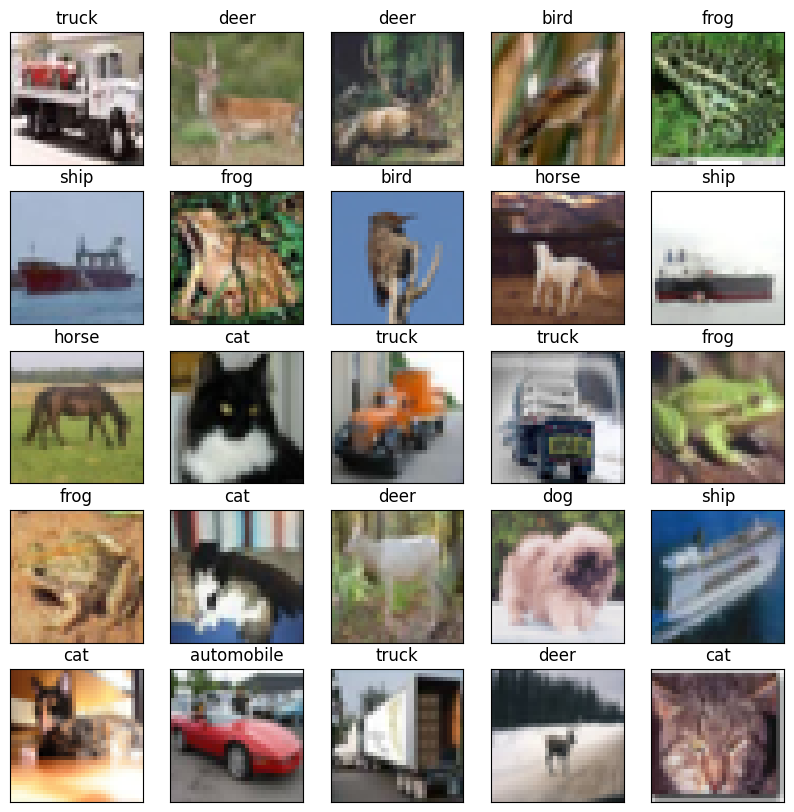

In [5]:
def show_random_grid(X: np.ndarray, Y: np.ndarray, grid_dim: tuple[int, int], vector_samples: bool) -> None:
    # Sample images are selected from the first.
    images = np.copy(X)
    labels = np.copy(Y)
    # Format the data accordingly.
    if vector_samples:
        images = images.reshape(len(images),3,32,32).transpose(0,2,3,1)

    # 25 Sample images will appear in a square grid.
    rows, columns = grid_dim
    # List with 25 random image indices.
    image_indices = random.sample(range(len(images)), rows * columns)
    # Their corresponding data. 
    images = [images[i] for i in image_indices]
    # Their corresponding labels. 
    labels = [labels[i] for i in image_indices]

    # Define figure
    fig=plt.figure(figsize=(2 * columns, 2 * rows))
    # Visualize these random images
    for i in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, i)
        plt.imshow(images[i-1])
        plt.xticks([])
        plt.yticks([])
        plt.title("{}".format(class_names[labels[i-1]]))
    plt.show()

show_random_grid(X_train, Y_train, grid_dim=(5, 5), vector_samples=True)

(elapsed: 0.7s)

### Scikit-Learn's SVM implementations
For this project, `sklearn.svm.SVC` will be used for training and evaluating an SVM on real-world data as the CIFAR10 dataset.

In [6]:
from sklearn.svm import SVC

In [24]:
# Normalize and flatten the data
X_train_flat = np.divide(X_train.reshape(-1, 32*32*3), 255.).astype(dtype=np.float32)
X_test_flat = np.divide(X_test.reshape(-1, 32*32*3), 255.).astype(dtype=np.float32)

print(X_train_flat.shape)
print(X_train_flat[0])

(50000, 3072)
[0.23137255 0.16862746 0.19607843 ... 0.54901963 0.32941177 0.28235295]


(elapsed: 0.5s)

Severe overhead was noticed during the preparation of this project when using the 3072-dimensional images of the original dataset.  
Thus, dimensionality reduction to `N_COMPONENTS` dimensionality, in which the initial images maintain 91% of their original information.

In [25]:
from sklearn.decomposition import PCA

pca = PCA(0.91).fit(X_train_flat)
X_train_reduced = pca.transform(X_train_flat)
X_test_reduced = pca.transform(X_test_flat)

N_COMPONENTS = X_train_reduced.shape[1]
print(X_train_reduced.shape)

(50000, 114)


(elapsed: 27.4s)

There is no need to declare number of inputs nor outputs as `sklearn.svm.SVC` can extract that information from the training set.

In [9]:
# SVC can automatically detect the number of classes in a dataset during fit()'s execution
id_frogs = [i for i in range(100) if Y_train[i] == class_names.index('frog')]
id_trucks = [i for i in range(100) if Y_train[i] == class_names.index('truck')]
id_birds = [i for i in range(100) if Y_train[i] == class_names.index('bird')]

# If the SVC is train only with frogs & birds, then it will have two output classes
outputs = SVC().fit(X_train_flat[id_birds + id_frogs], Y_train[id_birds + id_frogs]).classes_
print(outputs)
# If the SVC is fitted only with frogs, birds & trucks, then it will have three output classes
outputs = SVC().fit(X_train_flat[id_birds + id_frogs + id_trucks], Y_train[id_birds + id_frogs + id_trucks]).classes_
print(outputs)
# Our dataset has 10 classes, thus the SVC will have 10 outputs after training
outputs = SVC().fit(X_train_flat[:500], Y_train[:500]).classes_
print(outputs)

[2 6]
[2 6 9]
[0 1 2 3 4 5 6 7 8 9]


(elapsed: 0.2s)

Below, a grid search is performed to fine tune the model's parameters.  
* **RBF kernel:** The Radial Basis Function (RBF) kernel is one of the most popular and versatile kernels used in Support Vector Machines (SVMs), especially for non-linearly separable problems:
$$
K(\vec{x}, \vec{x}') = e^{-\gamma \| \vec{x} - \vec{x}'\|^2}
$$
* **C (Regularization parameter):** Fine tuning of C through searching many parameters.  
* **gamma (Kernel coefficient for RBF):** Two choices are searched for time efficiency:
    1. if gamma='scale' (default) is passed then it uses 1 / (n_features * X.var()) as value of gamma,  
    2. if ‘auto’, uses 1 / n_features

In [19]:
# DO NOT RUN THIS CELL
# Search Grid
param_grid = {
    'kernel': ['rbf'], 
    'C': [0.01, 0.1, 1, 2, 5, 10], 
    'gamma': ['scale', 'auto']
}

cv = GridSearchCV(estimator=SVC(random_state=RAND_SEED), param_grid=param_grid, n_jobs=8, cv=3).fit(X=X_train_reduced, y=Y_train)
# Show the best parameters
print(cv.best_params_)

# Save the best classifier in a .pickle file (It is already trained) 
# to avoid running this cell again.
with open('best_svc.pickle', 'wb') as file:
    pickle.dump(cv.best_estimator_, file)

{'C': 5, 'gamma': 'auto', 'kernel': 'rbf'}


(elapsed: 51m, 24.3s)

In [8]:
# Load the best classifier.
with open('best_svc.pickle', 'rb') as file:
    svc = pickle.load(file)

(elapsed: 0.1s)

### Results
It is evident that an `sklearn.svm.SVC` performs poorly in terms of classification accuracy in comparison to CNNs that can reach +80% test accuracy in CIFAR10.

In [21]:
print(f'Overall Test Accuracy: {100 * svc.score(X_test_reduced, Y_test):.2f}%')

Overall Test Accuracy: 56.35%


(elapsed: 43.7s)

### Simplification
We will simplify the problem to binary classification.  
The CIFAR10 dataset is already challenging enough for a Support Vector Classifier that distinguihses between samples of all 10 classes.  
One way to simplify the problem is training and evaluating an SVC according to only two classes.  
First, the 50000 training samples must be organized by their class, such as a list of 10 `numpy.ndarray`s of 5000 samples each.  
The i-th element of the list contains a numpy array of all samples of the i-th class. This is implemented in the code below.

In [27]:
# Training set organized by class.
X_train_classwise = [np.zeros((N_TRAIN // 10, N_COMPONENTS), dtype=np.float32) for _ in range(10)]
# Testing set organized by class.
X_test_classwise = [np.zeros((N_TEST // 10, N_COMPONENTS), dtype=np.float32) for _ in range(10)]

# Keep the number of registered samples of each class.
current_entries = [0 for _ in range(10)]
for i in range(N_TRAIN):
    # Take the target label of the i-th sample.
    tag = Y_train[i]
    # Fetch the position where the next element of the i-th class should be inserted
    j = current_entries[tag]
    # Increment the array counter of the i-th element's class
    current_entries[tag] += 1
    # Insert the i-th element to the correct position
    X_train_classwise[tag][j] = X_train_reduced[i]

# Repeat for the testing set.
current_entries = [0 for _ in range(10)]
for i in range(N_TEST):
    tag = Y_test[i]
    j = current_entries[tag]
    current_entries[tag] += 1
    X_test_classwise[tag][j] = X_test_reduced[i]

(elapsed: 0.1s)

In [28]:
# Take the labels of the 'dog' and 'truck' classes.
dog_id = class_names.index('dog')
truck_id = class_names.index('truck')

# Create a new training dataset that contains only images of dogs and trucks.
X_train_reduced_dog_truck = np.concatenate((X_train_classwise[dog_id], X_train_classwise[truck_id]), axis=0)
Y_train_dog_truck  = np.array(
    [dog_id for _ in range(N_TRAIN // 10)] + 
    [truck_id for _ in range(N_TRAIN // 10)]
)
# Create a new testing dataset that contains only images of dogs and trucks.
X_test_reduced_dog_truck  = np.concatenate((X_test_classwise[dog_id], X_test_classwise[truck_id]), axis=0)
Y_test_dog_truck  = np.array(
    [dog_id for _ in range(N_TEST // 10)] + 
    [truck_id for _ in range(N_TEST // 10)]
)
# The new training dataset has 2 * 5000 = 10000 samples
N_TRAIN_2 = N_TRAIN // 5
# The new training dataset has 2 * 1000 = 2000 samples
N_TEST_2 = N_TEST // 5

(elapsed: 0.1s)

In [29]:
# Take the indices of the training set.
train_indices = list(range(N_TRAIN_2))
# Shuffle them so that, equivallently, the training dataset will be "virtually" shuffled.
random.shuffle(train_indices)

X_train_reduced_dog_truck = X_train_reduced_dog_truck[train_indices]
Y_train_dog_truck = Y_train_dog_truck[train_indices]

# Train the SVM of the binary classification problem with the shuffled dataset.
binary_svc = SVC().fit(X_train_reduced_dog_truck, Y_train_dog_truck)

(elapsed: 3.0s)

In [12]:
# Test the results
print(f'Binary SVC test accuracy: {100 * binary_svc.score(X_test_reduced_dog_truck, Y_test_dog_truck):.2f}%')

Binary SVC test accuracy: 92.55%


(elapsed: 0.5s)

### Results
The Binary SVC `dog`/`truck` classification shows overwhelming improvement in accuracy.  
This could imply the possibility that a One vs One scheme could produce better results using:
$$
\frac{N_C \cdot (N_C - 1)}{2} = 45 \text{  binary SVCs}
$$

In [28]:
svc_ovo = SVC(C=5, gamma='auto', kernel='rbf', decision_function_shape='ovo').fit(X_train_reduced, Y_train)

(elapsed: 6m, 52.5s)

In [29]:
print(f'One vs One SVC test accuracy: {100 * svc_ovo.score(X_test_reduced, Y_test):.2f}%')

One vs One SVC test accuracy: 56.35%


(elapsed: 59.6s)

It seems that using OvO produces not very different results from the OvR scheme.

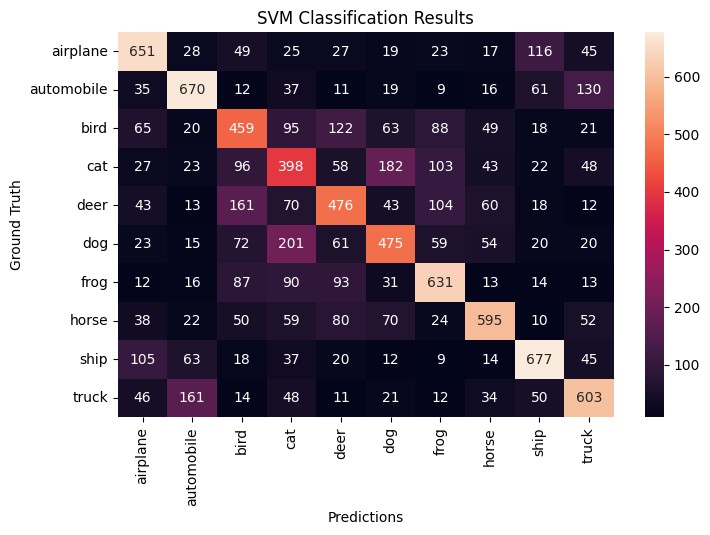

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get every prediction for test set.
Y_pred = svc.predict(X_test_reduced)
cm = confusion_matrix(Y_test, Y_pred)

# Plot predictions and ground truth using the confusion matrix.
plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predictions')
plt.ylabel('Ground Truth')
plt.title('SVM Classification Results')
pass

(elapsed: 43.2s)

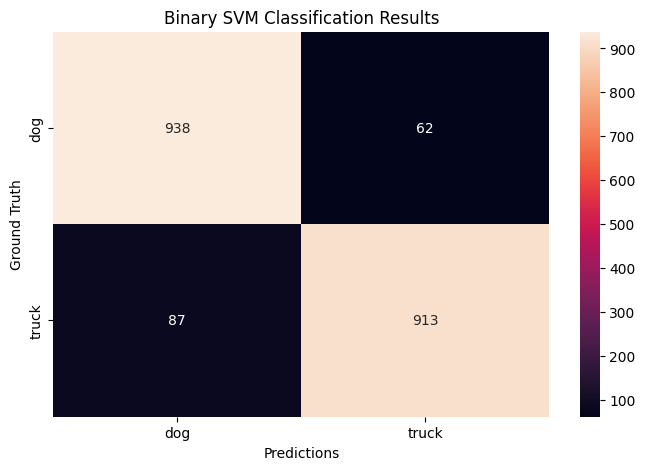

In [14]:
# Get every prediction for test set.
Y_pred_dog_truck = binary_svc.predict(X_test_reduced_dog_truck)
cm = confusion_matrix(Y_test_dog_truck, Y_pred_dog_truck)

# Plot predictions and ground truth using the confusion matrix.
plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=['dog', 'truck'], yticklabels=['dog', 'truck'])
plt.xlabel('Predictions')
plt.ylabel('Ground Truth')
plt.title('Binary SVM Classification Results')
pass

(elapsed: 0.7s)

### Square Hinge Loss for MLP
Below `NeuralNetwork.FullyConnectedClassifier` from the first project was extended to include the **Squared Hinge Loss** (L2-SVM) as an option for calculating the error during training. This will make the NN simulate an SVM's training process and behavior. In traditional SVMs, the objective is to find a hyperplane that maximally separates different classes. By using the squared hinge loss, the neural network is punished heavily when placing samples at the wrong side of the dividing surface **or** when placing them correctly but close to it. This way it is encouraged to learn features and weights that similarly aim to maximize the margin between classes.

<img src="./pics/maximum_margin.PNG" alt="Maximum margin visualization" style="height: 388px; width:459px;"/>

The above is observed in the Neural Network when using L2-SVM loss assuming that the samples are pictures in 114 (=N_COMPONENTS) dimensions and the maximum margin decision surface is not a hyperplane but a hypersurface. 

In [15]:
from NeuralNetwork import FullyConnectedClassifier

nnet = FullyConnectedClassifier(N_COMPONENTS, 10, 'relu', [(128, 'sigmoid'), (64, 'sigmoid')], 0.002, 'L2-SVM', dtype=np.float32)
print(nnet.diagnostics())

------------------ [Classifier Diagnostics] ------------------
> Learning Rate: η = 0.002
> Activation Function (Output): relu
> Error Function: L2-SVM
> Input Dim.: 114
> Output Dim.: 10
> Hidden Layers: (2 layers)
	* Neurons: 128, Activation: sigmoid
	* Neurons: 64, Activation: sigmoid
> Value Dim.:
	* v^(0): (114, 1)
	* v^(1): (128, 1)
	* v^(2): (64, 1)
	* v^(3): (10, 1)
> Weight & Bias Dim.:
	* W^(1): (128, 114), b^(1): (128, 1)
	* W^(2): (64, 128), b^(2): (64, 1)
	* W^(3): (10, 64), b^(3): (10, 1)
--------------------------------------------------------------



In [16]:
nnet.fit(X_train_reduced, Y_train, test=(X_test_reduced, Y_test), n_epochs=1000)

Finished epoch No.1, Elapsed Time: 14.01sec, Train Accuracy: 28.34%, Test Accuracy: 28.34%
Finished epoch No.2, Elapsed Time: 13.55sec, Train Accuracy: 30.51%, Test Accuracy: 30.46%
Finished epoch No.3, Elapsed Time: 13.16sec, Train Accuracy: 31.11%, Test Accuracy: 31.24%
Finished epoch No.4, Elapsed Time: 13.16sec, Train Accuracy: 31.51%, Test Accuracy: 31.63%
Finished epoch No.5, Elapsed Time: 13.12sec, Train Accuracy: 31.94%, Test Accuracy: 31.92%
Finished epoch No.6, Elapsed Time: 13.14sec, Train Accuracy: 32.38%, Test Accuracy: 32.34%
Finished epoch No.7, Elapsed Time: 13.19sec, Train Accuracy: 32.81%, Test Accuracy: 32.71%
Finished epoch No.8, Elapsed Time: 13.27sec, Train Accuracy: 33.16%, Test Accuracy: 33.08%
Finished epoch No.9, Elapsed Time: 13.23sec, Train Accuracy: 33.49%, Test Accuracy: 33.43%
Finished epoch No.10, Elapsed Time: 13.09sec, Train Accuracy: 33.77%, Test Accuracy: 33.47%
Finished epoch No.11, Elapsed Time: 13.09sec, Train Accuracy: 34.06%, Test Accuracy: 33.6

(elapsed: 3m, 35.2s)

It is obvious from the output that accuracy is increasing at the end of each epoch. Thus L2-SVM is a valid loss function to use in a Multilayer Perceptron.  
Below data augmentation will be performed to the dataset in hopes of achieving better results.

SVM's performance will be compared with `sklearn.neighbors.KNeighborsClassifier`'s and `sklearn.neighbors.NearestCentroid`'s accuracy and time performance.  Specifically:  
* 1 Nearest Neighbor
* 3 Nearest Neighbors
* Nearest Centroid

In [26]:
from time import perf_counter as timer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid

models = ['knn1', 'knn3', 'NC']
# Records of elapsed training time
train_times = {model : 0 for model in models}
# Records of testing accuracy
eval_scores = {model : 0 for model in models}
# Records of elapsed testing time
eval_times = {model : 0 for model in models}

knn1 = KNeighborsClassifier(n_neighbors=1, n_jobs=10)
knn3 = KNeighborsClassifier(n_neighbors=3, n_jobs=10)
cent = NearestCentroid()

# Training Segment
start = timer()
knn1.fit(X_train_reduced, Y_train)
stop = timer()
train_times['knn1'] = stop - start

start = timer()
knn3.fit(X_train_reduced, Y_train)
stop = timer()
train_times['knn3'] = stop - start

start = timer()
cent.fit(X_train_reduced, Y_train)
stop = timer()
train_times['NC'] = stop - start

# Training Report
for model in models:
    elapsed = train_times[model]
    print(f'[{model.upper()}] finished after {elapsed:.2f} seconds')

print()

# Testing Segment
start = timer()
eval_scores['knn1'] = knn1.score(X_test_reduced, Y_test)
stop = timer()
eval_times['knn1'] = stop - start

start = timer()
eval_scores['knn3'] = knn3.score(X_test_reduced, Y_test)
stop = timer()
eval_times['knn3'] = stop - start

start = timer()
eval_scores['NC'] = cent.score(X_test_reduced, Y_test)
stop = timer()
eval_times['NC'] = stop - start

# Testing Report
for model in models:
    elapsed = eval_times[model]
    score = eval_scores[model]
    print(f'[{model.upper()}] finished after {elapsed:.2f} seconds with {100 * score:.2f}% test accuracy')

[KNN1] finished after 0.01 seconds
[KNN3] finished after 0.01 seconds
[NC] finished after 0.02 seconds

[KNN1] finished after 0.88 seconds with 38.21% test accuracy
[KNN3] finished after 0.89 seconds with 36.33% test accuracy
[NC] finished after 0.01 seconds with 27.67% test accuracy


And now for the Binary problem of Dogs vs Trucks

In [30]:
from time import perf_counter as timer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid

models = ['knn1', 'knn3', 'NC']
# Records of elapsed training time
train_times = {model : 0 for model in models}
# Records of testing accuracy
eval_scores = {model : 0 for model in models}
# Records of elapsed testing time
eval_times = {model : 0 for model in models}

knn1 = KNeighborsClassifier(n_neighbors=1, n_jobs=10)
knn3 = KNeighborsClassifier(n_neighbors=3, n_jobs=10)
cent = NearestCentroid()

# Training Segment
start = timer()
knn1.fit(X_train_reduced_dog_truck, Y_train_dog_truck)
stop = timer()
train_times['knn1'] = stop - start

start = timer()
knn3.fit(X_train_reduced_dog_truck, Y_train_dog_truck)
stop = timer()
train_times['knn3'] = stop - start

start = timer()
cent.fit(X_train_reduced_dog_truck, Y_train_dog_truck)
stop = timer()
train_times['NC'] = stop - start

# Training Report
for model in models:
    elapsed = train_times[model]
    print(f'[{model.upper()}] finished after {elapsed:.2f} seconds')

print()

# Testing Segment
start = timer()
eval_scores['knn1'] = knn1.score(X_test_reduced_dog_truck, Y_test_dog_truck)
stop = timer()
eval_times['knn1'] = stop - start

start = timer()
eval_scores['knn3'] = knn3.score(X_test_reduced_dog_truck, Y_test_dog_truck)
stop = timer()
eval_times['knn3'] = stop - start

start = timer()
eval_scores['NC'] = cent.score(X_test_reduced_dog_truck, Y_test_dog_truck)
stop = timer()
eval_times['NC'] = stop - start

# Testing Report
for model in models:
    elapsed = eval_times[model]
    score = eval_scores[model]
    print(f'[{model.upper()}] finished after {elapsed:.2f} seconds with {100 * score:.2f}% test accuracy')

[KNN1] finished after 0.00 seconds
[KNN3] finished after 0.00 seconds
[NC] finished after 0.00 seconds

[KNN1] finished after 0.06 seconds with 82.45% test accuracy
[KNN3] finished after 0.05 seconds with 84.70% test accuracy
[NC] finished after 0.00 seconds with 76.80% test accuracy


### Data Augmentation
The train and test datasets will be reloaded and augmented by applying the following transformations on the images:  
1. Random Zooms  
2. Random Flips  
3. Random Contrasts  
4. Random Rotations  

This will be performed 3 times, effectively increasing x4 the dataset's size.

In [17]:
from keras import Sequential, layers 

(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()

Y_train = Y_train.reshape(-1,)
Y_test = Y_test.reshape(-1,)

input_transformer = Sequential([
    layers.experimental.preprocessing.RandomZoom(0.5, seed=RAND_SEED), 
    layers.experimental.preprocessing.RandomFlip(seed=RAND_SEED), 
    layers.experimental.preprocessing.RandomContrast(0.5, seed=RAND_SEED), 
    layers.experimental.preprocessing.RandomRotation(0.5, seed=RAND_SEED)
])
aug1 = np.array(input_transformer(X_train))
aug2 = np.array(input_transformer(X_train))
aug3 = np.array(input_transformer(X_train))

assert not np.equal(aug1, aug2).all()

X_train_aug = np.concatenate((X_train, aug1, aug2, aug3), axis=0)
Y_train_aug = np.concatenate(4 * (Y_train.ravel(), ))

assert X_train_aug.shape[0] == 4 * N_TRAIN
assert X_train_aug.shape[0] == Y_train_aug.shape[0]

N_TRAIN_AUG = X_train_aug.shape[0]

(elapsed: 11.6s)

In [18]:
indices = list(range(N_TRAIN_AUG))
random.shuffle(indices)

# Shuffle dataset
X_train_aug = X_train_aug[indices]
Y_train_aug = Y_train_aug[indices]

(elapsed: 1.7s)

Below, some random samples are selected and shown in a 7x7 grid to validate the augmentations and the shuffling (images and labels should match).

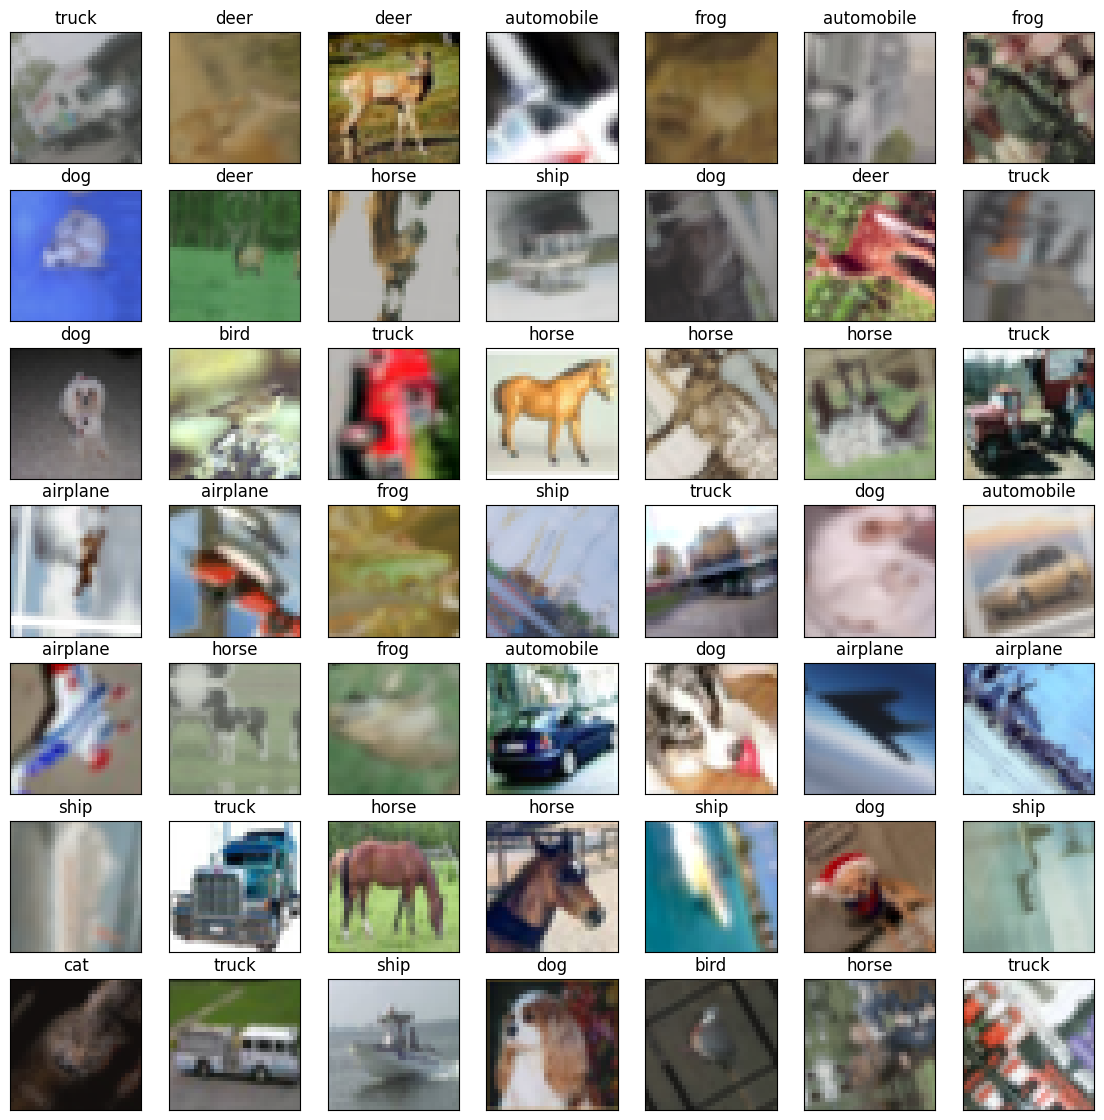

In [12]:
show_random_grid(X_train_aug / 255., Y_train_aug, grid_dim=(7, 7), vector_samples=False)

(elapsed: 1.2s)

In [19]:
# Normalize and flatten the data
X_train_aug_flat = np.divide(X_train_aug.reshape(-1, 32*32*3), 255.).astype(dtype=np.float32)

print(X_train_aug_flat.shape)
print(X_train_aug_flat[0])

(200000, 3072)
[0.03785527 0.02558184 0.0355179  ... 0.82730967 0.7035531  0.46302232]


(elapsed: 5.4s)

The augmented dataset will be analyzed to its principal components so that it maintains 91% of information.

In [20]:
from sklearn.decomposition import PCA

pca = PCA(0.91).fit(X_train_aug_flat)
X_train_aug_reduced = pca.transform(X_train_aug_flat)
X_test_reduced = pca.transform(X_test_flat)

N_COMPONENTS_AUG = X_train_aug_reduced.shape[1]
print(X_train_aug_reduced.shape)

(200000, 74)


(elapsed: 1m, 46.1s)

In [10]:
svm_aug = SVC(kernel='rbf', C=5, gamma='auto').fit(X=X_train_aug_reduced, y=Y_train_aug)

The code above was running for 8 hours and still didn't finish. The SVM's training time performance is unacceptable. Nothing is worth waiting that much.

In [ ]:
# Unknown performance
print(f'SVM\'s accuracy on the augmented dataset: {100 * svm_aug.score(X_test_reduced, Y_test):.2f}%')

We check the augmented dataset for the `KNearestNeighbors` and `NearestCentroid`

In [21]:
from time import perf_counter as timer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid

models = ['knn1', 'knn3', 'NC']
# Records of elapsed training time
train_times = {model : 0 for model in models}
# Records of testing accuracy
eval_scores = {model : 0 for model in models}
# Records of elapsed testing time
eval_times = {model : 0 for model in models}

knn1 = KNeighborsClassifier(n_neighbors=1, n_jobs=10)
knn3 = KNeighborsClassifier(n_neighbors=3, n_jobs=10)
cent = NearestCentroid()

# Training Segment
start = timer()
knn1.fit(X_train_aug_reduced, Y_train_aug)
stop = timer()
train_times['knn1'] = stop - start

start = timer()
knn3.fit(X_train_aug_reduced, Y_train_aug)
stop = timer()
train_times['knn3'] = stop - start

start = timer()
cent.fit(X_train_aug_reduced, Y_train_aug)
stop = timer()
train_times['NC'] = stop - start

# Training Report
for model in models:
    elapsed = train_times[model]
    print(f'[{model.upper()}] finished after {elapsed:.2f} seconds')

print()

# Testing Segment
start = timer()
eval_scores['knn1'] = knn1.score(X_test_reduced, Y_test)
stop = timer()
eval_times['knn1'] = stop - start

start = timer()
eval_scores['knn3'] = knn3.score(X_test_reduced, Y_test)
stop = timer()
eval_times['knn3'] = stop - start

start = timer()
eval_scores['NC'] = cent.score(X_test_reduced, Y_test)
stop = timer()
eval_times['NC'] = stop - start

# Testing Report
for model in models:
    elapsed = eval_times[model]
    score = eval_scores[model]
    print(f'[{model.upper()}] finished after {elapsed:.2f} seconds with {100 * score:.2f}% test accuracy')

[KNN1] finished after 0.03 seconds
[KNN3] finished after 0.02 seconds
[NC] finished after 0.05 seconds

[KNN1] finished after 2.57 seconds with 11.46% test accuracy
[KNN3] finished after 2.34 seconds with 11.80% test accuracy
[NC] finished after 0.01 seconds with 14.61% test accuracy


(elapsed: 5s)

It's obvious that data augmentation didn't turn out very successful as the SVM wouldn't train and KNearestNeighbors and NearestCentroid have shown a decrease in accuracy.

### KNN & Nearest Centroid vs SVM

It seems that even though SVM (<i>56.35% acc.</i>) is more powerful than `KNeatestNeighbors` (<i>~37%__ acc.</i>) and `NearestCentroid` (<i>27.67%__ acc.</i>), It takes significantly much more time to train and predict. The SVM performs better even at the binary classification problem of dogs vs trucks.